In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)  
pd.set_option('display.float_format', lambda x: '%.5f' % x)  
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import MultipleLocator
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import joblib
import scipy.stats
from time import *
from tqdm import tnrange, tqdm_notebook
from time import sleep
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Concatenate, Add
from tensorflow.python.keras.utils.vis_utils import plot_model

In [3]:
X_col = ['FAT',
 'STP',
 'Water',
 'Tem',
 'SOC',
 'TN',
 'pH',
 'BD',
 'Clay',
 'CEC',
 'Nrate',
 'UOA',
 'others',
 'CRF',
 'manure',
 'AN',
 'SBC',
 'Mix',
 'DPM',
 'Rice',
 'Wheat',
 'Maize']

In [4]:
train = pd.read_excel('./train.xlsx')
test = pd.read_excel('./test.xlsx')

In [82]:
RF = joblib.load('./RF_V6_112.pkl')
pt = joblib.load('./boxcox_V6.pkl')

In [7]:
x_train = train[X_col]
x_train_rf = train[X_col]
y_train = train['EF'].values.reshape(len(train),1)
x_test = test[X_col]
x_test_rf = test[X_col]
y_test = test['EF'].values.reshape(len(test),1)

In [8]:
#FNN ResNet

In [9]:
x_train.shape, x_test.shape

((2103, 22), (526, 22))

In [10]:
y_train.shape, y_test.shape

((2103, 1), (526, 1))

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [12]:
train_Y = np.array(y_train)
test_Y = np.array(y_test)

In [13]:
x_train.columns

Index(['FAT', 'STP', 'Water', 'Tem', 'SOC', 'TN', 'pH', 'BD', 'Clay', 'CEC', 'Nrate', 'UOA', 'others', 'CRF', 'manure', 'AN', 'SBC', 'Mix', 'DPM', 'Rice', 'Wheat', 'Maize'], dtype='object')

In [14]:
x_train_1 = x_train[['Water', 'Tem', 'SOC', 'TN', 'pH', 'BD', 'Clay', 'CEC', 'Nrate']]
x_train_2 = x_train[['FAT', 'STP','UOA', 'others', 'CRF', 'manure','AN', 'SBC', 'Mix', 'DPM', 'Rice', 'Wheat', 'Maize']]

In [15]:
x_test_1 = x_test[['Water', 'Tem', 'SOC', 'TN', 'pH', 'BD', 'Clay', 'CEC', 'Nrate']]
x_test_2 = x_test[['FAT', 'STP','UOA', 'others', 'CRF', 'manure','AN', 'SBC', 'Mix', 'DPM', 'Rice', 'Wheat', 'Maize']]

In [16]:
# Normalize the training and test data
train_stats = x_train_1.describe()
train_stats = train_stats.transpose()

norm_train_X = norm(x_train_1)
norm_test_X = norm(x_test_1)

In [17]:
norm_train_X = pd.concat([norm_train_X,x_train_2],axis=1)
norm_test_X = pd.concat([norm_test_X,x_test_2],axis=1)
x_train = norm_train_X
x_test = norm_test_X

In [18]:
# Define model layers.  FNN
input_layer = Input(shape=(len(x_train.columns),))
x = Dense(units='256', activation='relu')(input_layer)
x = Dense(units='256', activation='relu')(x)
x = Dense(units='64', activation='relu')(x)
# output will come via the third dense
y_output = Dense(units='1', name='y_output')(x)

# Define the model with the input layer and a list of output layers
FNN = Model(inputs=input_layer, outputs=y_output)

#plot_model(model, show_shapes=True, show_layer_names=True)
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
print(FNN.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense (Dense)               (None, 256)               5888      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 y_output (Dense)            (None, 1)                 65        
                                                                 
Total params: 88,193
Trainable params: 88,193
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
FNN.compile(optimizer=optimizer,
              loss={'y_output': 'mse'},
              metrics={'y_output': tf.keras.metrics.RootMeanSquaredError()})

E:\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [20]:
# Train the model for 500 epochs
history = FNN.fit(norm_train_X, train_Y,
                    epochs=500, validation_data=(norm_test_X, test_Y), batch_size=32)

Epoch 1/500
66/66 [==============================] - 0s 2ms/step - loss: 7.8271 - root_mean_squared_error: 2.7977 - val_loss: 4.2291 - val_root_mean_squared_error: 2.0565
Epoch 2/500
66/66 [==============================] - 0s 1ms/step - loss: 3.8825 - root_mean_squared_error: 1.9704 - val_loss: 3.1243 - val_root_mean_squared_error: 1.7676
Epoch 3/500
66/66 [==============================] - 0s 1ms/step - loss: 3.4069 - root_mean_squared_error: 1.8458 - val_loss: 2.9923 - val_root_mean_squared_error: 1.7298
Epoch 4/500
66/66 [==============================] - 0s 1ms/step - loss: 3.2670 - root_mean_squared_error: 1.8075 - val_loss: 2.9056 - val_root_mean_squared_error: 1.7046
Epoch 5/500
66/66 [==============================] - 0s 1ms/step - loss: 3.1738 - root_mean_squared_error: 1.7815 - val_loss: 2.8327 - val_root_mean_squared_error: 1.6831
Epoch 6/500
66/66 [==============================] - 0s 1ms/step - loss: 3.1030 - root_mean_squared_error: 1.7615 - val_loss: 2.7810 - val_root_m

Epoch 49/500
66/66 [==============================] - 0s 1ms/step - loss: 2.1416 - root_mean_squared_error: 1.4634 - val_loss: 1.9818 - val_root_mean_squared_error: 1.4078
Epoch 50/500
66/66 [==============================] - 0s 2ms/step - loss: 2.1238 - root_mean_squared_error: 1.4573 - val_loss: 1.9834 - val_root_mean_squared_error: 1.4083
Epoch 51/500
66/66 [==============================] - 0s 2ms/step - loss: 2.1025 - root_mean_squared_error: 1.4500 - val_loss: 1.9614 - val_root_mean_squared_error: 1.4005
Epoch 52/500
66/66 [==============================] - 0s 1ms/step - loss: 2.0855 - root_mean_squared_error: 1.4441 - val_loss: 1.9441 - val_root_mean_squared_error: 1.3943
Epoch 53/500
66/66 [==============================] - 0s 1ms/step - loss: 2.0642 - root_mean_squared_error: 1.4367 - val_loss: 1.9350 - val_root_mean_squared_error: 1.3911
Epoch 54/500
66/66 [==============================] - 0s 1ms/step - loss: 2.0484 - root_mean_squared_error: 1.4312 - val_loss: 1.9190 - val_

66/66 [==============================] - 0s 1ms/step - loss: 1.0431 - root_mean_squared_error: 1.0213 - val_loss: 1.3901 - val_root_mean_squared_error: 1.1790
Epoch 144/500
66/66 [==============================] - 0s 1ms/step - loss: 1.0376 - root_mean_squared_error: 1.0186 - val_loss: 1.3664 - val_root_mean_squared_error: 1.1689
Epoch 145/500
66/66 [==============================] - 0s 1ms/step - loss: 1.0372 - root_mean_squared_error: 1.0185 - val_loss: 1.3880 - val_root_mean_squared_error: 1.1781
Epoch 146/500
66/66 [==============================] - 0s 1ms/step - loss: 1.0283 - root_mean_squared_error: 1.0141 - val_loss: 1.3819 - val_root_mean_squared_error: 1.1755
Epoch 147/500
66/66 [==============================] - 0s 1ms/step - loss: 1.0226 - root_mean_squared_error: 1.0112 - val_loss: 1.3554 - val_root_mean_squared_error: 1.1642
Epoch 148/500
66/66 [==============================] - 0s 1ms/step - loss: 1.0260 - root_mean_squared_error: 1.0129 - val_loss: 1.3799 - val_root_mea

66/66 [==============================] - 0s 1ms/step - loss: 0.6869 - root_mean_squared_error: 0.8288 - val_loss: 1.1757 - val_root_mean_squared_error: 1.0843
Epoch 238/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6916 - root_mean_squared_error: 0.8316 - val_loss: 1.1873 - val_root_mean_squared_error: 1.0896
Epoch 239/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6768 - root_mean_squared_error: 0.8227 - val_loss: 1.1620 - val_root_mean_squared_error: 1.0779
Epoch 240/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6755 - root_mean_squared_error: 0.8219 - val_loss: 1.1535 - val_root_mean_squared_error: 1.0740
Epoch 241/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6711 - root_mean_squared_error: 0.8192 - val_loss: 1.1764 - val_root_mean_squared_error: 1.0846
Epoch 242/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6806 - root_mean_squared_error: 0.8250 - val_loss: 1.1913 - val_root_mea

66/66 [==============================] - 0s 1ms/step - loss: 0.5566 - root_mean_squared_error: 0.7461 - val_loss: 1.1518 - val_root_mean_squared_error: 1.0732
Epoch 332/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5598 - root_mean_squared_error: 0.7482 - val_loss: 1.4034 - val_root_mean_squared_error: 1.1847
Epoch 333/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5834 - root_mean_squared_error: 0.7638 - val_loss: 1.0912 - val_root_mean_squared_error: 1.0446
Epoch 334/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5723 - root_mean_squared_error: 0.7565 - val_loss: 1.1611 - val_root_mean_squared_error: 1.0775
Epoch 335/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5641 - root_mean_squared_error: 0.7511 - val_loss: 1.1693 - val_root_mean_squared_error: 1.0814
Epoch 336/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5604 - root_mean_squared_error: 0.7486 - val_loss: 1.1530 - val_root_mea

66/66 [==============================] - 0s 1ms/step - loss: 0.5398 - root_mean_squared_error: 0.7347 - val_loss: 1.1902 - val_root_mean_squared_error: 1.0910
Epoch 426/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4976 - root_mean_squared_error: 0.7054 - val_loss: 1.1891 - val_root_mean_squared_error: 1.0905
Epoch 427/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4858 - root_mean_squared_error: 0.6970 - val_loss: 1.1631 - val_root_mean_squared_error: 1.0784
Epoch 428/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4810 - root_mean_squared_error: 0.6935 - val_loss: 1.1031 - val_root_mean_squared_error: 1.0503
Epoch 429/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5017 - root_mean_squared_error: 0.7083 - val_loss: 1.0835 - val_root_mean_squared_error: 1.0409
Epoch 430/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5072 - root_mean_squared_error: 0.7122 - val_loss: 1.3373 - val_root_mea

In [21]:
# Test the model and print loss and mse for both outputs
Y_loss, Y_rmse = FNN.evaluate(x=norm_test_X, y=test_Y)
print("Y_loss = {}, Y_mse = {}".format(Y_loss, Y_rmse))

17/17 [==============================] - 0s 623us/step - loss: 1.3412 - root_mean_squared_error: 1.1581
Y_loss = 1.3411645889282227, Y_mse = 1.1580866575241089


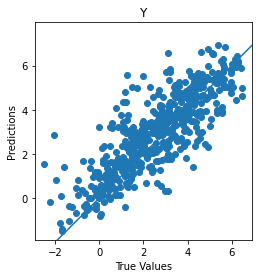

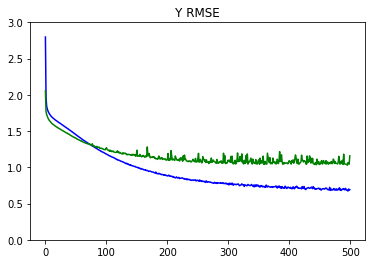

In [22]:
# Plot the loss and mse
Y_pred = FNN.predict(x_test)
plot_diff(test_Y, Y_pred, title='Y')
plot_metrics(metric_name='root_mean_squared_error', title='Y RMSE', ylim=3)

In [23]:
r2_score(test_Y, Y_pred)

0.619795975525742

In [24]:
# Define model layers.
input_layer = Input(shape=(len(x_train.columns),))
x = Dense(units='256', activation='relu')(input_layer)
x_1 = Dense(units='256', activation='relu')(x)
#Res_1
x = Dense(units='256', activation='relu')(x_1)
x = Dense(units='256')(x)
x = Add()([x, x_1])
x_2 = Activation('relu')(x)
##Res_2
#x = Dense(units='128', activation='relu')(x_2)
#x = Dense(units='128')(x)
#x = Add()([x, x_2])
#x_3 = Activation('relu')(x)
##Res_3
#x = Dense(units='128', activation='relu')(x_3)
#x = Dense(units='128')(x)
#x = Add()([x, x_3])
#x = Activation('relu')(x)
#
x = Dense(units='64', activation='relu')(x_2)
# output will come via the third dense
y_output = Dense(units='1', name='y_output')(x)

# Define the model with the input layer and a list of output layers
ResNet = Model(inputs=input_layer, outputs=y_output)

#plot_model(model, show_shapes=True, show_layer_names=True)
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
print(ResNet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 22)]         0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          5888        ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 256)          65792       ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 256)          65792       ['dense_4[0][0]']                
                                                                                            

In [25]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
ResNet.compile(optimizer=optimizer,
              loss={'y_output': 'mse'},
              metrics={'y_output': tf.keras.metrics.RootMeanSquaredError()})

E:\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [26]:
# Train the model for 500 epochs
history = ResNet.fit(norm_train_X, train_Y,
                    epochs=500, validation_data=(norm_test_X, test_Y), batch_size=32)

Epoch 1/500
66/66 [==============================] - 0s 2ms/step - loss: 5.6813 - root_mean_squared_error: 2.3836 - val_loss: 3.3225 - val_root_mean_squared_error: 1.8228
Epoch 2/500
66/66 [==============================] - 0s 1ms/step - loss: 3.5028 - root_mean_squared_error: 1.8716 - val_loss: 3.0036 - val_root_mean_squared_error: 1.7331
Epoch 3/500
66/66 [==============================] - 0s 1ms/step - loss: 3.2426 - root_mean_squared_error: 1.8007 - val_loss: 2.8505 - val_root_mean_squared_error: 1.6884
Epoch 4/500
66/66 [==============================] - 0s 1ms/step - loss: 3.1174 - root_mean_squared_error: 1.7656 - val_loss: 2.7701 - val_root_mean_squared_error: 1.6644
Epoch 5/500
66/66 [==============================] - 0s 1ms/step - loss: 3.0363 - root_mean_squared_error: 1.7425 - val_loss: 2.6871 - val_root_mean_squared_error: 1.6392
Epoch 6/500
66/66 [==============================] - 0s 1ms/step - loss: 2.9721 - root_mean_squared_error: 1.7240 - val_loss: 2.6326 - val_root_m

Epoch 49/500
66/66 [==============================] - 0s 1ms/step - loss: 1.5988 - root_mean_squared_error: 1.2644 - val_loss: 1.6259 - val_root_mean_squared_error: 1.2751
Epoch 50/500
66/66 [==============================] - 0s 1ms/step - loss: 1.5687 - root_mean_squared_error: 1.2525 - val_loss: 1.6125 - val_root_mean_squared_error: 1.2698
Epoch 51/500
66/66 [==============================] - 0s 1ms/step - loss: 1.5282 - root_mean_squared_error: 1.2362 - val_loss: 1.5895 - val_root_mean_squared_error: 1.2608
Epoch 52/500
66/66 [==============================] - 0s 1ms/step - loss: 1.5220 - root_mean_squared_error: 1.2337 - val_loss: 1.5815 - val_root_mean_squared_error: 1.2576
Epoch 53/500
66/66 [==============================] - 0s 2ms/step - loss: 1.4872 - root_mean_squared_error: 1.2195 - val_loss: 1.5595 - val_root_mean_squared_error: 1.2488
Epoch 54/500
66/66 [==============================] - 0s 2ms/step - loss: 1.4513 - root_mean_squared_error: 1.2047 - val_loss: 1.5398 - val_

66/66 [==============================] - 0s 1ms/step - loss: 0.7079 - root_mean_squared_error: 0.8414 - val_loss: 1.2389 - val_root_mean_squared_error: 1.1130
Epoch 144/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6494 - root_mean_squared_error: 0.8059 - val_loss: 1.2303 - val_root_mean_squared_error: 1.1092
Epoch 145/500
66/66 [==============================] - 0s 1ms/step - loss: 0.7358 - root_mean_squared_error: 0.8578 - val_loss: 1.1172 - val_root_mean_squared_error: 1.0570
Epoch 146/500
66/66 [==============================] - 0s 1ms/step - loss: 0.7915 - root_mean_squared_error: 0.8896 - val_loss: 1.2465 - val_root_mean_squared_error: 1.1164
Epoch 147/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6862 - root_mean_squared_error: 0.8284 - val_loss: 1.1324 - val_root_mean_squared_error: 1.0641
Epoch 148/500
66/66 [==============================] - 0s 1ms/step - loss: 0.6785 - root_mean_squared_error: 0.8237 - val_loss: 1.3113 - val_root_mea

66/66 [==============================] - 0s 1ms/step - loss: 0.5735 - root_mean_squared_error: 0.7573 - val_loss: 1.1122 - val_root_mean_squared_error: 1.0546
Epoch 238/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5668 - root_mean_squared_error: 0.7529 - val_loss: 1.0982 - val_root_mean_squared_error: 1.0480
Epoch 239/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5642 - root_mean_squared_error: 0.7511 - val_loss: 1.1364 - val_root_mean_squared_error: 1.0660
Epoch 240/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5248 - root_mean_squared_error: 0.7244 - val_loss: 1.0876 - val_root_mean_squared_error: 1.0429
Epoch 241/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5536 - root_mean_squared_error: 0.7440 - val_loss: 1.1838 - val_root_mean_squared_error: 1.0880
Epoch 242/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5068 - root_mean_squared_error: 0.7119 - val_loss: 1.0968 - val_root_mea

66/66 [==============================] - 0s 1ms/step - loss: 0.4500 - root_mean_squared_error: 0.6708 - val_loss: 1.1158 - val_root_mean_squared_error: 1.0563
Epoch 332/500
66/66 [==============================] - 0s 1ms/step - loss: 0.5069 - root_mean_squared_error: 0.7120 - val_loss: 1.2176 - val_root_mean_squared_error: 1.1035
Epoch 333/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4589 - root_mean_squared_error: 0.6774 - val_loss: 1.0755 - val_root_mean_squared_error: 1.0371
Epoch 334/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4596 - root_mean_squared_error: 0.6779 - val_loss: 1.2020 - val_root_mean_squared_error: 1.0964
Epoch 335/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4873 - root_mean_squared_error: 0.6981 - val_loss: 1.4351 - val_root_mean_squared_error: 1.1979
Epoch 336/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4731 - root_mean_squared_error: 0.6878 - val_loss: 1.1003 - val_root_mea

66/66 [==============================] - 0s 1ms/step - loss: 0.4245 - root_mean_squared_error: 0.6516 - val_loss: 1.0912 - val_root_mean_squared_error: 1.0446
Epoch 426/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4267 - root_mean_squared_error: 0.6532 - val_loss: 1.0792 - val_root_mean_squared_error: 1.0388
Epoch 427/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4955 - root_mean_squared_error: 0.7039 - val_loss: 1.0654 - val_root_mean_squared_error: 1.0322
Epoch 428/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4352 - root_mean_squared_error: 0.6597 - val_loss: 1.2008 - val_root_mean_squared_error: 1.0958
Epoch 429/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4239 - root_mean_squared_error: 0.6511 - val_loss: 1.3418 - val_root_mean_squared_error: 1.1584
Epoch 430/500
66/66 [==============================] - 0s 1ms/step - loss: 0.4174 - root_mean_squared_error: 0.6460 - val_loss: 1.0789 - val_root_mea

In [27]:
# Test the model and print loss and mse for both outputs
Y_loss, Y_rmse = ResNet.evaluate(x=norm_test_X, y=test_Y)
print("Y_loss = {}, Y_mse = {}".format(Y_loss, Y_rmse))

17/17 [==============================] - 0s 685us/step - loss: 1.1696 - root_mean_squared_error: 1.0815
Y_loss = 1.1695878505706787, Y_mse = 1.0814749002456665


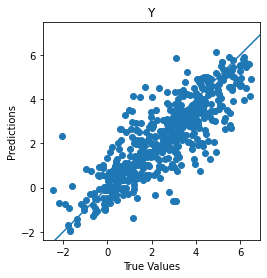

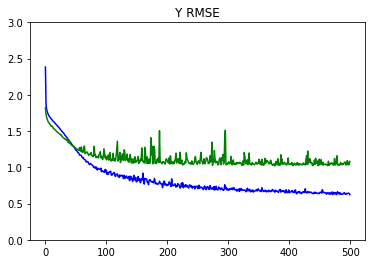

In [28]:
# Plot the loss and mse
Y_pred = ResNet.predict(norm_test_X)
plot_diff(test_Y, Y_pred, title='Y')
plot_metrics(metric_name='root_mean_squared_error', title='Y RMSE', ylim=3)

In [29]:
r2_score(test_Y, Y_pred)

0.6684359626660754

In [30]:
begin_time = time()

In [31]:
from sklearn.svm import SVR

In [32]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
kernel = [ 'rbf']
C = np.linspace(0,200,201)

In [33]:
param_grid = {'kernel': kernel,'C': C}

In [34]:
grid_SVM = GridSearchCV(SVR(), param_grid, cv=10,n_jobs = 7,return_train_score=False)

In [35]:
grid_SVM.fit(x_train, y_train.ravel())

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 2010.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "E:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "E:\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 333, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 192, in sklearn.svm._libsvm.fit
ValueErr

GridSearchCV(cv=10, estimator=SVR(), n_jobs=7,
             param_grid={'C': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  7...
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164.,
       165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186.,
       187., 188., 189., 190., 191., 192., 193., 194., 195., 196., 197.,
       198., 199., 200.]),
                         'kernel': ['rbf']})

In [36]:
grid_SVM.best_params_

{'C': 82.0, 'kernel': 'rbf'}

In [37]:
SVM = SVR(kernel=grid_SVM.best_params_['kernel'],C=grid_SVM.best_params_['C'])

In [38]:
SVM = SVR(kernel='rbf',C=82)

In [39]:
SVM.fit(x_train, y_train.ravel())

SVR(C=82)

In [40]:
SVM.score(x_test, y_test)

0.6717560917530767

In [41]:
SVM.score(x_train, y_train)

0.8418768145671164

In [42]:
np.sqrt(mean_squared_error(SVM.predict(x_test), y_test))

1.0760464624934007

In [43]:
end_time = time()
run_time = end_time-begin_time
print ('time cost：',run_time/60, 'min') 

time cost： 3.8663553396860757 min


In [44]:
from sklearn.linear_model import Ridge

In [45]:
alpha = np.linspace(0,100,1001)

In [46]:
param_grid = {'alpha': alpha}

In [47]:
grid_Ridge = GridSearchCV(Ridge(), param_grid, cv=10,n_jobs = 7,return_train_score=False)

In [48]:
grid_Ridge.fit(x_train, y_train.ravel())

GridSearchCV(cv=10, estimator=Ridge(), n_jobs=7,
             param_grid={'alpha': array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])})

In [49]:
grid_Ridge.best_params_

{'alpha': 13.4}

In [50]:
ridge = Ridge(alpha=grid_Ridge.best_params_['alpha'])

In [51]:
ridge.fit(x_train, y_train.ravel())

Ridge(alpha=13.4)

In [52]:
ridge.score(x_test, y_test)

0.24013384113210956

In [53]:
ridge.score(x_train, y_train)

0.227185195835916

In [54]:
np.sqrt(mean_squared_error(ridge.predict(x_test), y_test))

1.6371981238808082

In [65]:
from sklearn.linear_model import ElasticNet

In [66]:
alpha = np.linspace(0,100,1001)
l1_ratio = np.linspace(0,1,11)

In [67]:
param_grid = {'alpha': alpha,'l1_ratio': l1_ratio}

In [68]:
grid_ElasticNet = GridSearchCV(ElasticNet(), param_grid, cv=10,n_jobs = 7,return_train_score=False)

In [69]:
grid_ElasticNet.fit(x_train, y_train.ravel())

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
E:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+03, tolerance: 8.186e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=7,
             param_grid={'alpha': array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [70]:
grid_ElasticNet.best_params_

{'alpha': 0.0, 'l1_ratio': 0.0}

In [71]:
Elastic = ElasticNet(alpha=grid_ElasticNet.best_params_['alpha'],l1_ratio=grid_ElasticNet.best_params_['l1_ratio'])

In [72]:
Elastic.fit(x_train, y_train.ravel())

<ipython-input-72-a70783b75bf8>:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  Elastic.fit(x_train, y_train.ravel())
E:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
E:\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e+03, tolerance: 8.186e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.0, l1_ratio=0.0)

In [73]:
Elastic.score(x_test, y_test)

0.23928487021705447

In [74]:
Elastic.score(x_train, y_train)

0.22746940964097317

In [75]:
np.sqrt(mean_squared_error(Elastic.predict(x_test), y_test))

1.6381124596222174

In [55]:
begin_time = time()

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

In [57]:
max_features= range(1,22)
min_samples_leaf = range(1,5)
learning_rate = [0.001, 0.01, 0.1, 1]
max_depth = [3, 5, 8, 15, 25, 30, None]

In [59]:
param_grid = {'max_features': max_features,'min_samples_leaf': min_samples_leaf,
             'learning_rate':learning_rate, 'max_depth':max_depth}

In [60]:
grid_GBDT = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=10,n_jobs = 7,return_train_score=False)

In [61]:
grid_GBDT.fit(x_train, y_train.ravel())

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=7,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_depth': [3, 5, 8, 15, 25, 30, None],
                         'max_features': range(1, 22),
                         'min_samples_leaf': range(1, 5)})

In [62]:
grid_GBDT.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 7,
 'min_samples_leaf': 2}

In [63]:
GBDT = GradientBoostingRegressor(n_estimators=500, max_features=grid_GBDT.best_params_['max_features'],min_samples_leaf = grid_GBDT.best_params_['min_samples_leaf'],learning_rate = grid_GBDT.best_params_['learning_rate'],max_depth = grid_GBDT.best_params_['max_depth'],random_state=2022)
GBDT.fit(x_train, y_train.ravel())

GradientBoostingRegressor(max_depth=8, max_features=7, min_samples_leaf=2,
                          n_estimators=500, random_state=2022)

In [65]:
GBDT.score(x_test, y_test)

0.7748181168127217

In [66]:
GBDT.score(x_train, y_train)

0.9486865293411686

In [67]:
np.sqrt(mean_squared_error(GBDT.predict(x_test), y_test))

0.8912497273964526

In [68]:
end_time = time()
run_time = end_time-begin_time
print ('time cost：',run_time/60, 'min') 

time cost： 23.903263155619303 min


In [69]:
#n_estimators = range(100,101)
#random_state = range(112,113)
#max_features= range(1,22)
#min_samples_leaf = range(1,5)
#max_depth = [3, 5, 8, 15, 25, 30, None] 

In [70]:
n_estimators = range(500,501)
random_state = range(112,113)
max_features= range(10,15)
min_samples_leaf = range(1,2)
max_depth = [ 15, 25, 30, None]

In [71]:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
             'random_state': random_state,
             'min_samples_leaf': min_samples_leaf,
             'max_depth': max_depth}

In [72]:
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=10,n_jobs = 7,return_train_score=False)

In [73]:
begin_time = time()

In [74]:
grid.fit(x_train, y_train.ravel())
#grid.fit(X, Y.ravel())

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=7,
             param_grid={'max_depth': [15, 25, 30, None],
                         'max_features': range(10, 15),
                         'min_samples_leaf': range(1, 2),
                         'n_estimators': range(500, 501),
                         'random_state': range(112, 113)})

In [75]:
end_time = time()
run_time = end_time-begin_time
print ('time cost：',run_time/60, 'min') #该循环程序运行时间： 1.4201874732

time cost： 1.1625678936640422 min


In [76]:
grid.best_params_

{'max_depth': 30,
 'max_features': 14,
 'min_samples_leaf': 1,
 'n_estimators': 500,
 'random_state': 112}

In [77]:
RF_2 = RandomForestRegressor(n_estimators=500, max_features=14,random_state=112,max_depth = None)

In [78]:
RF_2.fit(x_train, y_train.ravel())

RandomForestRegressor(max_features=14, n_estimators=500, random_state=112)

In [79]:
RF_2.score(x_test, y_test)

0.7804999721717651

In [80]:
np.sqrt(mean_squared_error(RF_2.predict(x_test), y_test))

0.8799337520034551

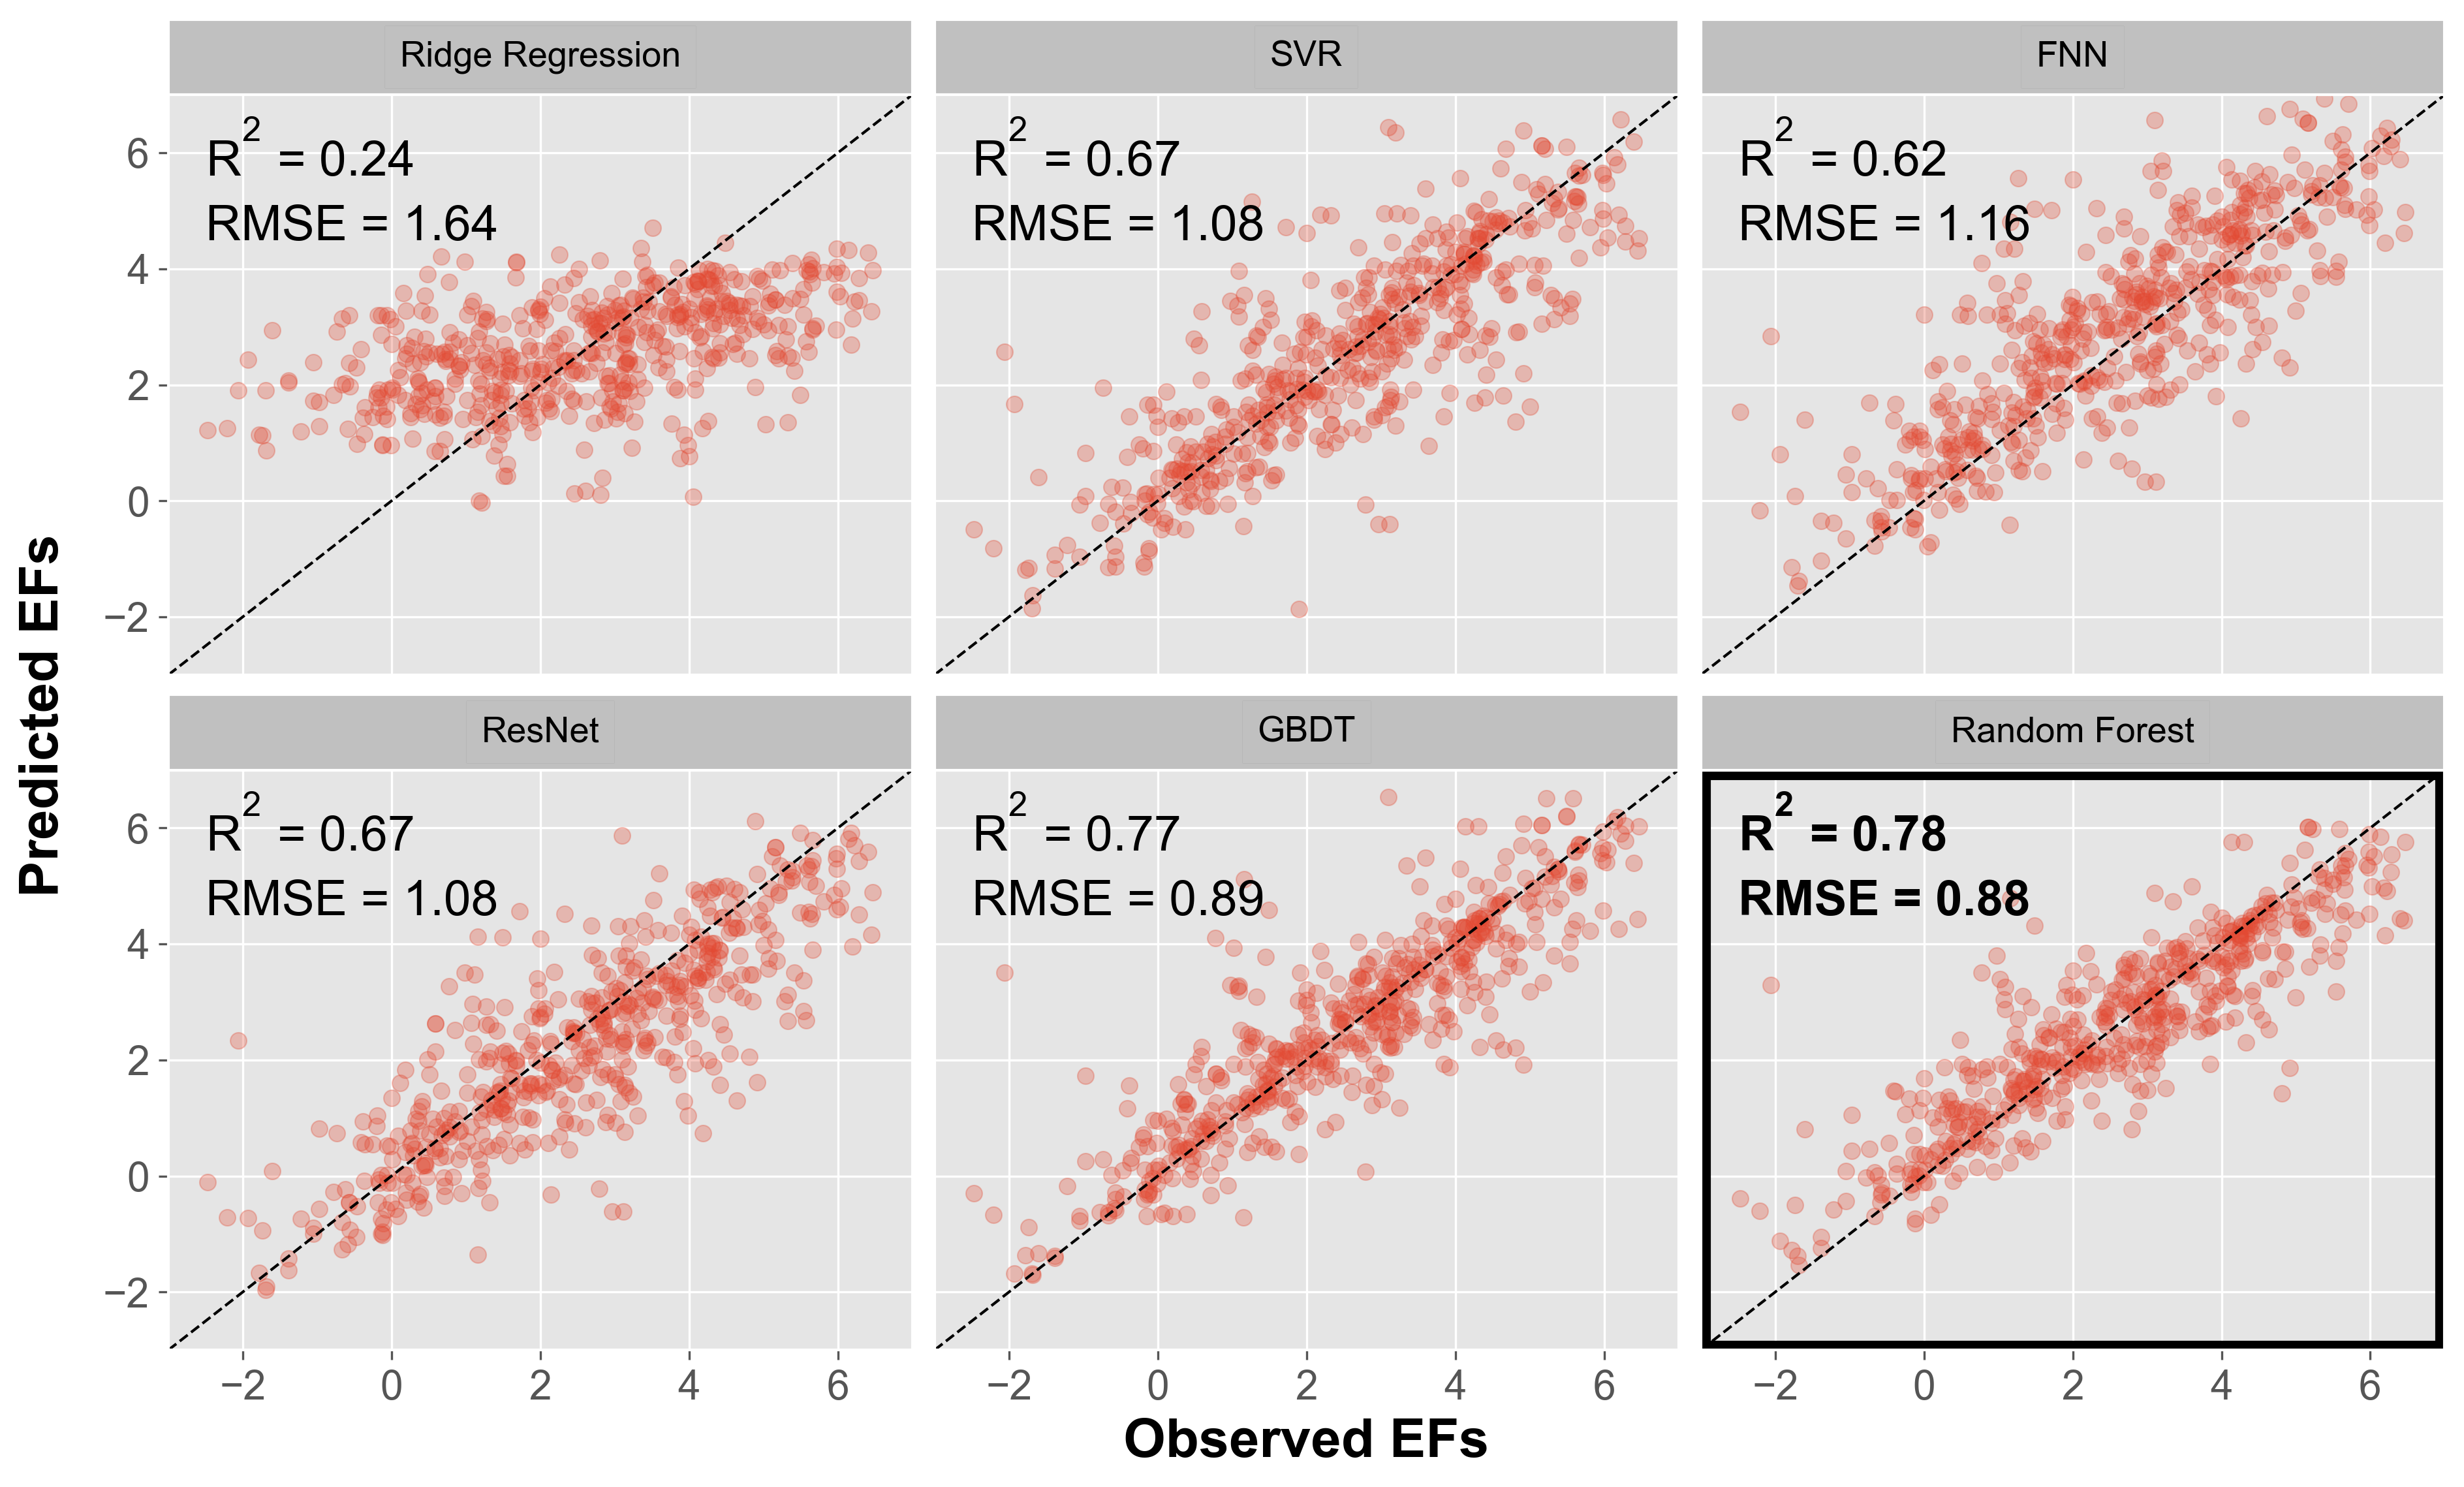

In [114]:
plt.figure(figsize=(15,9),dpi=300)
plt.rc('font',family='Arial')  #改字体
plt.style.use('ggplot')
plt.subplots_adjust(wspace =0.03, hspace =0.03)#调整子图间距



plt.subplot(2, 3, 1)
plt.scatter(y_test, ridge.predict(x_test),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), ridge.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(-2.5, 5.6, 'Ridge', fontsize=15)
plt.text(-2.5, 5.6, 'R$\mathregular{^2}$ = ' + str(round(ridge.score(x_test, y_test), 2)), fontsize=18)
plt.text(-2.5, 4.5, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,ridge.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
plt.gca().axes.xaxis.set_ticklabels([])
#plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=False, top=False, left=True, right=False)
plt.xlim((-3, 7))
plt.ylim((-3, 7))
plt.gca().tick_params(labelsize=15) #刻度字体大小
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("Ridge Regression", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 2)
plt.scatter(y_test, SVM.predict(x_test),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), SVM.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(-2.5, 5.6, 'SVM', fontsize=15)
plt.text(-2.5, 5.6, 'R$\mathregular{^2}$ = ' + str(round(SVM.score(x_test, y_test), 2)), fontsize=18)
plt.text(-2.5, 4.5, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,SVM.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.xlim((-3, 7))
plt.ylim((-3, 7))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("SVR", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 3)
plt.scatter(y_test, FNN.predict(x_test),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), FNN.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(-2.5, 5.6, 'FNN', fontsize=15)
plt.text(-2.5, 5.6, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, FNN.predict(x_test)), 2)), fontsize=18)
plt.text(-2.5, 4.5, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,FNN.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.xlim((-3, 7))
plt.ylim((-3, 7))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("FNN", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)


plt.subplot(2, 3, 4)
plt.scatter(y_test, ResNet.predict(x_test),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), ResNet.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=20,weight='bold',color = 'black')  #轴标题
plt.text(-5,5,'Predicted EFs', fontsize=20,weight='bold',color = 'black',rotation = 90)  #轴标题
#plt.text(-2.5, 5.6, 'ResNet', fontsize=15)
plt.text(-2.5, 5.6, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, ResNet.predict(x_test)), 2)), fontsize=18)
plt.text(-2.5, 4.5, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,ResNet.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
#plt.gca().axes.xaxis.set_ticklabels([])
#plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=True, top=False, left=True, right=False)
plt.xlim((-3, 7))
plt.ylim((-3, 7))
plt.gca().tick_params(labelsize=15) #刻度字体大小
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("ResNet", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 5)
plt.scatter(y_test, GBDT.predict(x_test),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), GBDT.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
plt.xlabel('Observed EFs', fontsize=20,weight='bold',color = 'black')  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(-2.5, 5.6, 'GBDT', fontsize=15)
plt.text(-2.5, 5.6, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, GBDT.predict(x_test)), 2)), fontsize=18)
plt.text(-2.5, 4.5, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test, GBDT.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
#plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=True, top=False, left=False, right=False)
plt.xlim((-3, 7))
plt.ylim((-3, 7))
plt.gca().tick_params(labelsize=15) #刻度字体大小
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("GBDT", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 6)
plt.scatter(y_test, RF_2.predict(x_test),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), RF_2.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
plt.plot((0, 0), (0, 1.2), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
plt.plot((0, 1), (0, 0), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
plt.plot((1, 1), (0, 1), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
plt.plot((0, 1), (1, 1), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(-2.5, 5.6, 'Random Forest', fontsize=15)
plt.text(-2.5, 5.6, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, RF_2.predict(x_test)), 2)), fontsize=18,weight='bold')
plt.text(-2.5, 4.5, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,RF_2.predict(x_test))),2)), fontsize=18,weight='bold')
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
#plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=True, top=False, left=False, right=False)
plt.xlim((-3, 7))
plt.ylim((-3, 7))
plt.gca().tick_params(labelsize=15) #刻度字体大小

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')
at = AnchoredText("Random Forest", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)
#[cax.spines[loc_axis].set_linewidth(1.5) for loc_axis in ['top','right','bottom','left']] #边框宽度

#cax.outline.set_linewidth(2)

#cax.dividers.set_color('white')
#cax.dividers.set_linewidth(2)

#plt.savefig('./不同模型表现.png', dpi = 1000,bbox_inches = 'tight')  #保存图片

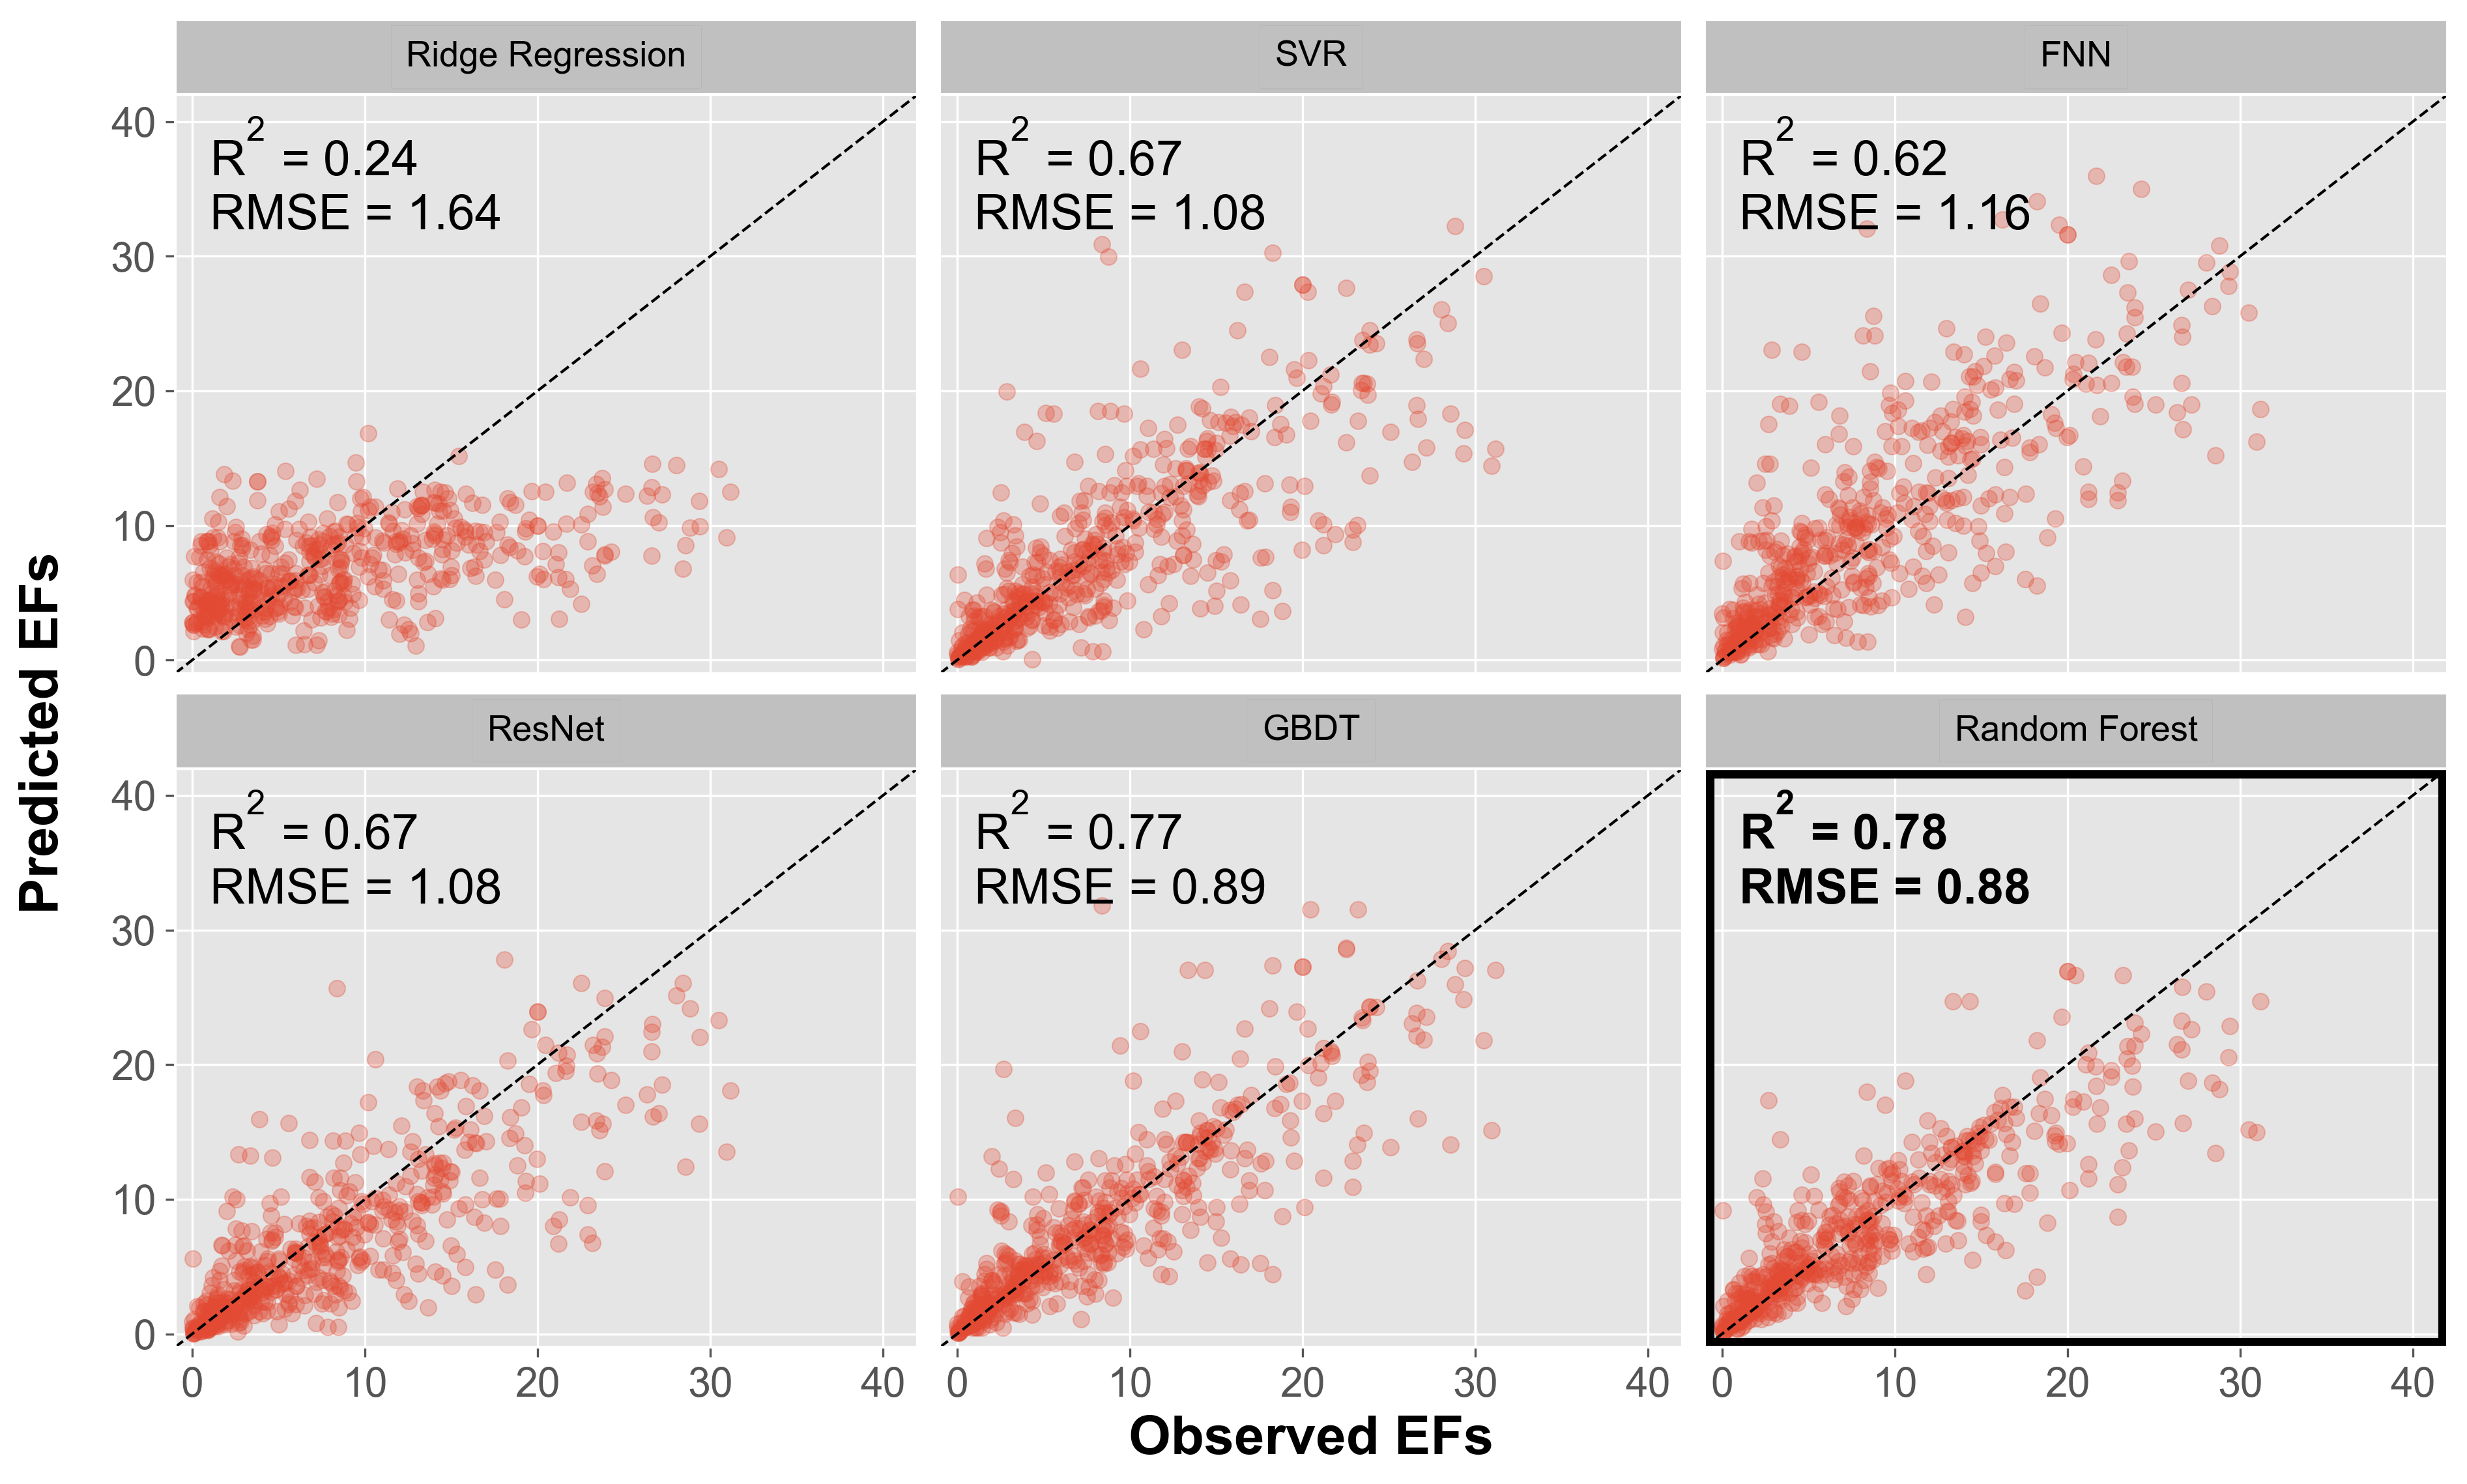

In [128]:
plt.figure(figsize=(15,9),dpi=300)
plt.rc('font',family='Arial')  #改字体
plt.style.use('ggplot')
plt.subplots_adjust(wspace =0.03, hspace =0.03)#调整子图间距



plt.subplot(2, 3, 1)
plt.scatter(pt.inverse_transform(y_test), pt.inverse_transform(ridge.predict(x_test).reshape(-1,1)),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), ridge.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(1, 36, 'Ridge', fontsize=15)
plt.text(1, 36, 'R$\mathregular{^2}$ = ' + str(round(ridge.score(x_test, y_test), 2)), fontsize=18)
plt.text(1, 32, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,ridge.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
plt.gca().axes.xaxis.set_ticklabels([])
#plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=False, top=False, left=True, right=False)
plt.xlim((-1, 42))
plt.ylim((-1, 42))
plt.gca().tick_params(labelsize=15) #刻度字体大小
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("Ridge Regression", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 2)
plt.scatter(pt.inverse_transform(y_test), pt.inverse_transform(SVM.predict(x_test).reshape(-1,1)),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), SVM.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(1, 36, 'SVM', fontsize=15)
plt.text(1, 36, 'R$\mathregular{^2}$ = ' + str(round(SVM.score(x_test, y_test), 2)), fontsize=18)
plt.text(1, 32, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,SVM.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.xlim((-1, 42))
plt.ylim((-1, 42))
plt.xticks([0,10,20,30,40])
plt.yticks([0,10,20,30,40])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("SVR", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 3)
plt.scatter(pt.inverse_transform(y_test), pt.inverse_transform(FNN.predict(x_test).reshape(-1,1)),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), FNN.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(1, 36, 'FNN', fontsize=15)
plt.text(1, 36, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, FNN.predict(x_test)), 2)), fontsize=18)
plt.text(1, 32, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,FNN.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.xlim((-1, 42))
plt.ylim((-1, 42))
plt.xticks([0,10,20,30,40])
plt.yticks([0,10,20,30,40])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("FNN", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)


plt.subplot(2, 3, 4)
plt.scatter(pt.inverse_transform(y_test), pt.inverse_transform(ResNet.predict(x_test).reshape(-1,1)),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), ResNet.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=20,weight='bold',color = 'black')  #轴标题
plt.text(-10,32,'Predicted EFs', fontsize=20,weight='bold',color = 'black',rotation = 90)  #轴标题
#plt.text(1, 36, 'ResNet', fontsize=15)
plt.text(1, 36, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, ResNet.predict(x_test)), 2)), fontsize=18)
plt.text(1, 32, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,ResNet.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
#plt.gca().axes.xaxis.set_ticklabels([])
#plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=True, top=False, left=True, right=False)
plt.xlim((-1, 42))
plt.ylim((-1, 42))
plt.gca().tick_params(labelsize=15) #刻度字体大小
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("ResNet", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 5)
plt.scatter(pt.inverse_transform(y_test), pt.inverse_transform(GBDT.predict(x_test).reshape(-1,1)),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), GBDT.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
plt.xlabel('Observed EFs', fontsize=20,weight='bold',color = 'black')  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(1, 36, 'GBDT', fontsize=15)
plt.text(1, 36, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, GBDT.predict(x_test)), 2)), fontsize=18)
plt.text(1, 32, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test, GBDT.predict(x_test))),2)), fontsize=18)
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
#plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=True, top=False, left=False, right=False)
plt.xlim((-1, 42))
plt.ylim((-1, 42))
plt.gca().tick_params(labelsize=15) #刻度字体大小
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')

at = AnchoredText("GBDT", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)

plt.subplot(2, 3, 6)
plt.scatter(pt.inverse_transform(y_test), pt.inverse_transform(RF_2.predict(x_test).reshape(-1,1)),alpha=0.3)
#model1 = np.poly1d(np.polyfit(y_test.flatten(), RF_2.predict(x_test).flatten(), 3))
#polyline = np.linspace(-3, 7, 100)
#plt.plot(polyline, model1(polyline), color='k',lw = 1)
plt.plot((0, 1), (0, 1), transform=plt.gca().transAxes, ls='--',c='k', label="1:1 line",lw = 1)
plt.plot((0, 0), (0, 1.2), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
plt.plot((0, 1), (0, 0), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
plt.plot((1, 1), (0, 1), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
plt.plot((0, 1), (1, 1), transform=plt.gca().transAxes, ls='-',c='k',lw = 7)
#plt.plot((0, 30)+rmse, (0, 30), ls='--', c = "r")
#plt.xlabel('Observations', fontsize=15,)  #轴标题
#plt.ylabel('Predictions', fontsize=15)  #轴标题
#plt.text(1, 36, 'Random Forest', fontsize=15)
plt.text(1, 36, 'R$\mathregular{^2}$ = ' + str(round(r2_score(y_test, RF_2.predict(x_test)), 2)), fontsize=18,weight='bold')
plt.text(1, 32, 'RMSE = ' + str(round(np.sqrt(mean_squared_error(y_test,RF_2.predict(x_test))),2)), fontsize=18,weight='bold')
#plt.text(-2, 3.3, 'MAE: ' + str(round(mean_absolute_error(RF.predict(x_test), y_test),2)), fontsize=15)
#plt.text(-2, 3.3, 'n: ' + str(x_test.shape[0]), fontsize=15)
#plt.gca().axes.xaxis.set_ticklabels([])
plt.gca().axes.yaxis.set_ticklabels([])
plt.tick_params(bottom=True, top=False, left=False, right=False)
plt.xlim((-1, 42))
plt.ylim((-1, 42))
plt.gca().tick_params(labelsize=15) #刻度字体大小

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", size="13%", pad=0)
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_facecolor('silver')
at = AnchoredText("Random Forest", loc=10,
                  prop=dict(backgroundcolor='silver',
                            size=13, color='k'))
cax.add_artist(at)
#[cax.spines[loc_axis].set_linewidth(1.5) for loc_axis in ['top','right','bottom','left']] #边框宽度

#cax.outline.set_linewidth(2)

#cax.dividers.set_color('white')
#cax.dividers.set_linewidth(2)

plt.savefig('./不同模型表现_没标准化.png', dpi = 1000,bbox_inches = 'tight')  #保存图片